In [65]:
import plotly.express as px
#df = px.data.iris()
fig = px.parallel_coordinates(df,
                             color_continuous_scale=px.colors.diverging.Tealrose,
                             color_continuous_midpoint=2)
fig.show()

In [1]:
import pandas as pd
import numpy as np
from copy import deepcopy

In [48]:
url = 'https://raw.githubusercontent.com/imohitmayank/ranking_algorithm_intro/master/cars_multi.csv'
df = pd.read_csv(url).sample(15,random_state=200) #nie zmieniaj proszę, na końcu niech będzie chociaż 20,random_state=200

df =  df[['mpg','horsepower', 'weight', 'acceleration', 'price']]

df = df.dropna()
df = df[df.horsepower != '?']
df['horsepower'] = df.horsepower.astype(int)

# print(sorted(df['mpg'].unique())) #tylko aby sprawdzić, czy nie ma dziwnych znaków
df = df.reset_index(drop = True)

df.describe()

,mpg,horsepower,weight,acceleration,price
count,15.000000,15.000000,15.000000,15.000000,15.000000
mean,27.506667,96.533333,2764.800000,15.606667,31636.861725
std,7.956351,25.536715,747.619002,3.048762,11805.499037
min,15.000000,65.000000,1975.000000,12.900000,8844.146509
25%,24.500000,73.000000,2261.500000,14.000000,25497.506880
50%,27.200000,93.000000,2434.000000,14.700000,30000.000000
75%,35.050000,110.000000,2995.000000,16.000000,37907.553690
max,39.400000,145.000000,4440.000000,24.800000,52035.833620


In [49]:
#q p v type_of the cathegory = {"gain", "cost"}
c = 'cost'
g = 'gain'
q = [5, 40, 400, 1, 3000]
p = [12, 80, 800,  3, 7000]
v = [25,160, 2000, 10, 25000]
cat_type = [g,g,g,g,c]
qpv = pd.DataFrame([q,p,v,cat_type], columns = df.columns, index = ["q (indifference)","p (preference)","v (veto)","type_of cathegory"])
qpv


,mpg,horsepower,weight,acceleration,price
q (indifference),5,40,400,1,3000
p (preference),12,80,800,3,7000
v (veto),25,160,2000,10,25000
type_of cathegory,gain,gain,gain,gain,cost


In [50]:
weights = np.array([4.,1., 1., 3., 5.])
weights = [np.array(weights/sum(weights)).transpose()]
# print(weights.shape)
weights=pd.DataFrame(weights, index=["weight"], columns = df.columns)
weights

,mpg,horsepower,weight,acceleration,price
weight,0.285714,0.071429,0.071429,0.214286,0.357143


In [51]:
def preference_function(a, b, qpv, reverse = False):
    if reverse is True:
        a,b = b,a
    q, p, v, category_type = qpv
    
    if category_type == "gain":
        d = a-b
    elif category_type == "cost":
        d = b-a
    else:
        assert("Sorry, wrong category type.")
    
    if d > p:
        return 1
    elif d <= q:
        return 0
    else:
        return (d-q)/(p-q)



In [52]:
#demo
preference_function(400, 1000, [100, 300, -1, "cost"])

1

In [53]:
def marginal_preferenc_indices(df, criteria, qpv):
    out = np.zeros((len(df), len(df)), dtype = np.float64)
    for i, di in df.iterrows():
        for j, dj in df.iterrows():
            out[i][j] += preference_function(di[criteria], dj[criteria], qpv[criteria])
    return np.array(out)

In [54]:
#demo
np.array(marginal_preferenc_indices(df, "mpg", qpv))

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.57142857, 0.57142857, 0.        , 0.        , 0.        ,
        0.        , 0.42857143, 0.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        , 0.6       , 0.        ,
        1.        , 1.        , 0.        , 0.71428571, 0.54285714,
        0.54285714, 1.        , 0.85714286, 0.44285714, 0.        ],
       [0.72857143, 0.        , 0.        , 0.32857143, 0.        ,
        1.        , 1.        , 0.        , 0.44285714, 0.27142857,
        0.27142857, 1.        , 0.58571429, 0.17142857, 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.97142857, 0.97142857, 0.        , 0.        , 0.        ,
        0.        , 0.82857143, 0.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        , 0.6       , 0.        ,
        1.        , 1.        , 0.        , 0.71428571, 0.54285714,
        0.54285714, 1.        , 0.85714286, 

In [55]:
def comprehensive_preference_indices(df, qpv, weights):
    out = np.zeros((len(df), len(df)))
    criterias = df.columns
    for c in criterias:
        out += marginal_preferenc_indices(df, c, qpv) * weights[c]["weight"]
    return out

In [56]:
#demo
cpi = comprehensive_preference_indices(df, qpv, weights)
print(cpi)

[[0.         0.00982143 0.05982143 0.36785714 0.         0.16326531
  0.16326531 0.35714286 0.         0.         0.18843033 0.37379785
  0.12229081 0.35714286 0.39107143]
 [0.28571429 0.         0.         0.59285714 0.05357143 0.33928571
  0.28571429 0.35714286 0.20408163 0.15510204 0.34353237 0.53706316
  0.36058162 0.48367347 0.35714286]
 [0.58673469 0.35714286 0.         0.59030612 0.12857143 0.7138964
  0.30714286 0.35714286 0.43139742 0.2239237  0.43469388 0.64285714
  0.5244898  0.40612245 0.35714286]
 [0.         0.01696429 0.07589286 0.         0.         0.27755102
  0.27755102 0.         0.         0.00714286 0.         0.23673469
  0.02089286 0.27788376 0.05      ]
 [0.64285714 0.35714286 0.         0.52857143 0.         0.64285714
  0.28571429 0.35714286 0.56122449 0.5122449  0.5122449  0.64285714
  0.60204082 0.48367347 0.35714286]
 [0.12896074 0.18253217 0.14285714 0.42857143 0.10892857 0.
  0.         0.45178571 0.09285714 0.13214286 0.44285714 0.36607143
  0.48928571 

In [91]:
def prometheeIMatrix(pos_flow, neg_flow):
    out = np.zeros((len(pos_flow), len(pos_flow)))
    for (pos_i, i), (neg_i, _) in zip(pos_flow, neg_flow):
        for (pos_j, j), (neg_j, _) in zip(pos_flow, neg_flow):
            if (pos_i > pos_j and neg_i < neg_j) or \
               (pos_i == pos_j and neg_i < neg_j) or \
                (pos_i > pos_j and neg_i == neg_j):
                out[i][j] = 1
            elif pos_i == pos_j and neg_i == neg_j:
                out[i][j] = 0
            else:
                out[i][j] = -1
    return out
    

In [92]:
#PROMETHEE I
pos_flow = list(cpi.sum(1))
neg_flow = list(cpi.sum(0))
pos = list(zip(pos_flow, [c for c in range(len(df))]))
neg = list(zip(neg_flow, [c for c in range(len(df))]))
#example from lectures
#pos = [(3.7, 0), (0.25, 1), (0.7, 2), (1.55, 3), (4.05, 4), (2.65, 5)]
#neg = [(0.45, 0), (4, 1), (4.05, 2), (2.45, 3), (0.6, 4), (1.35, 5)]

#Preference = 1
#Indifference = 0
#Incomparable = -1
print([i for i, _ in pos])
print([i for i, _ in neg])
M = prometheeIMatrix(pos, neg)
print(M)

[2.5539067471938774, 4.355462869642857, 6.061564466964286, 1.240613351658163, 6.485714285714285, 3.8864929071428573, 6.3446428571428575, 2.907108357397959, 3.912001074234694, 7.348708717346938, 2.300345178061224, 4.315079698214285, 3.245030621428572, 1.213954081632653, 6.299295262372449]
[3.859098798341837, 2.5964712473214293, 1.6809948979591836, 6.865366690943877, 2.1482142857142854, 5.614406607653061, 4.054081632653061, 5.3064285714285715, 3.0037443608418366, 2.008974722959184, 4.4498198479591835, 5.883054889285716, 4.454760185714286, 6.403538035586735, 4.140965701785714]
[[ 0. -1. -1.  1. -1. -1. -1. -1. -1. -1.  1. -1. -1.  1. -1.]
 [ 1.  0. -1.  1. -1.  1. -1.  1.  1. -1.  1.  1.  1.  1. -1.]
 [ 1.  1.  0.  1. -1.  1. -1.  1.  1. -1.  1.  1.  1.  1. -1.]
 [-1. -1. -1.  0. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.]
 [ 1.  1. -1.  1.  0.  1.  1.  1.  1. -1.  1.  1.  1.  1.  1.]
 [-1. -1. -1.  1. -1.  0. -1. -1. -1. -1. -1. -1. -1.  1. -1.]
 [-1. -1. -1.  1. -1.  1.  0.  1. -1. -1.

In [137]:
def bestThree(M, n = 3, best = 1):
    row_sum = [(sum(M[i][j] for j in range(len(M[i])) if M[i][j] == best), i) for i in range(len(M))]
    
    row_sum.sort(reverse = bool(best > 0))#False if best else True)
    out = []
    print(row_sum)
    for i in range(n):
        if i < len(row_sum):
            out.append(row_sum[i][1])
    return out

In [142]:
bestThree(M, best = -1)

[(-14.0, 3), (-14.0, 13), (-12.0, 5), (-12.0, 7), (-12.0, 10), (-12.0, 11), (-11.0, 0), (-11.0, 12), (-7.0, 8), (-7.0, 14), (-6.0, 6), (-5.0, 1), (-4.0, 2), (-2.0, 4), (-1.0, 9)]


[3, 13, 5]

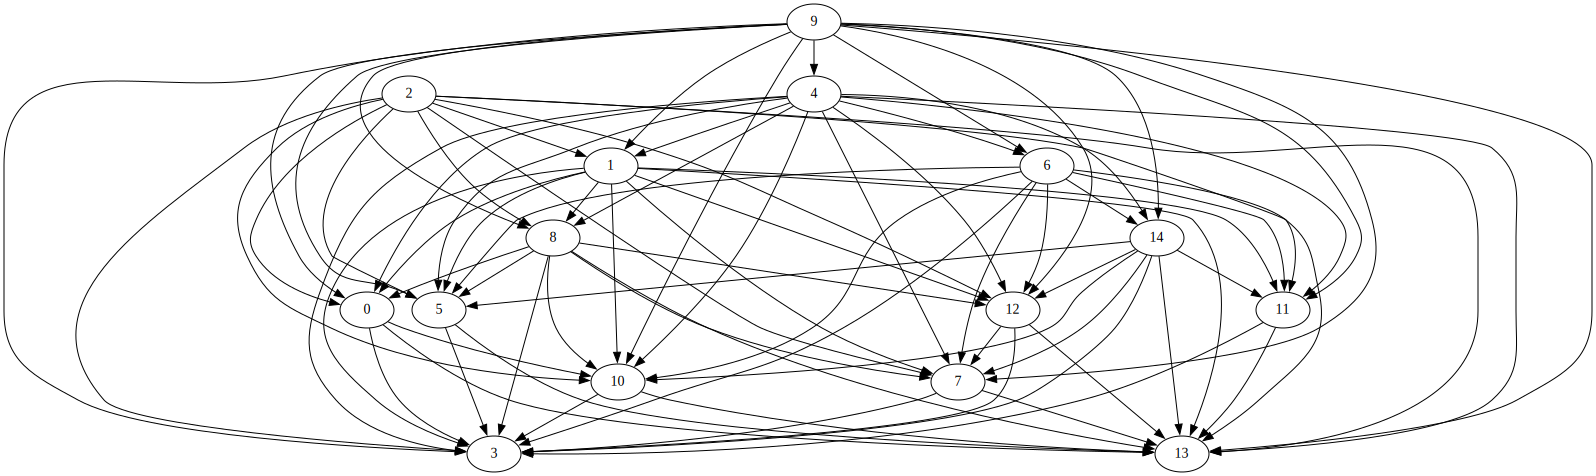

In [68]:
import graphviz
f = graphviz.Digraph()
for _, n in pos:
    f.node(str(n))
for i in range(len(pos)):
    for j in range(len(pos)):
        if M[i][j] == 1:
            f.edge(str(i), str(j))
        #elif M[i][j] == -1:
        #    f.edge(str(j), str(i))
f

In [60]:
#PROMETHEE II
phi = [(pos_phi - neg_phi, alternative) for (pos_phi, alternative), (neg_phi, _) in zip(pos, neg)]
phi.sort(reverse = True)
print(phi)
for _, alternative in phi:
    print(alternative, "-->", end = " ")
print("{end}")

[(5.339733994387753, 9), (4.380569569005102, 2), (4.3374999999999995, 4), (2.290561224489797, 6), (2.1583295605867345, 14), (1.7589916223214273, 1), (0.9082567133928574, 8), (-1.209729564285714, 12), (-1.3051920511479596, 0), (-1.5679751910714304, 11), (-1.7279137005102037, 5), (-2.1494746698979594, 10), (-2.3993202140306127, 7), (-5.189583953954082, 13), (-5.624753339285714, 3)]
9 --> 2 --> 4 --> 6 --> 14 --> 1 --> 8 --> 12 --> 0 --> 11 --> 5 --> 10 --> 7 --> 13 --> 3 --> {end}


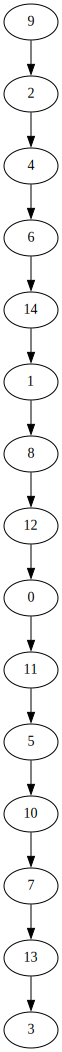

In [61]:
import graphviz
f = graphviz.Digraph()
for _, n in phi:
    f.node(str(n))
for i in range(len(phi)-1):
    f.edge(str(phi[i][1]), str(phi[i+1][1]))
f

In [55]:
df

,mpg,horsepower,weight,acceleration,price
0,24.0,110,2660,14.0,30000.00000
1,36.0,75,2205,14.5,30000.00000
2,34.1,65,1975,15.2,20000.00000
3,26.8,115,2700,12.9,45923.53551
4,36.0,84,2370,13.0,17421.62690
